*   Nama Lengkap : Adisaputra Zidha Noorizki
*   Username : hi_zidha
*   Email : hi.zidha@gmail.com

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.losses import Huber
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IDCamp2023/Intermediate/dataset/householdenergy.csv')

df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [ ]:
df.isnull().sum()

TYPE              0
DATE              0
START TIME        0
END TIME          0
USAGE             0
UNITS             0
COST              0
NOTES         70368
dtype: int64

In [ ]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['START TIME'] = pd.to_datetime(df['START TIME'])
df['END TIME'] = pd.to_datetime(df['END TIME'])

duration = (df['END TIME'] - df['START TIME']).astype(str).str.split().str[-1]

num_unique_durations = len(duration.unique())
print(f"Number of unique: {num_unique_durations} | {duration.unique()}")

Number of unique: 1 | ['00:14:00']


In [ ]:
df = df.drop(columns=['TYPE', 'START TIME', 'END TIME', 'UNITS', 'COST', 'NOTES'])
df = df.head(15000)
df

,DATE,USAGE
0,2016-10-22,0.01
1,2016-10-22,0.01
2,2016-10-22,0.01
3,2016-10-22,0.01
4,2016-10-22,0.01
...,...,...
14995,2017-03-27,0.01
14996,2017-03-27,0.02
14997,2017-03-27,0.02
14998,2017-03-27,0.02


Text(0.5, 1.0, 'Electricity Use')

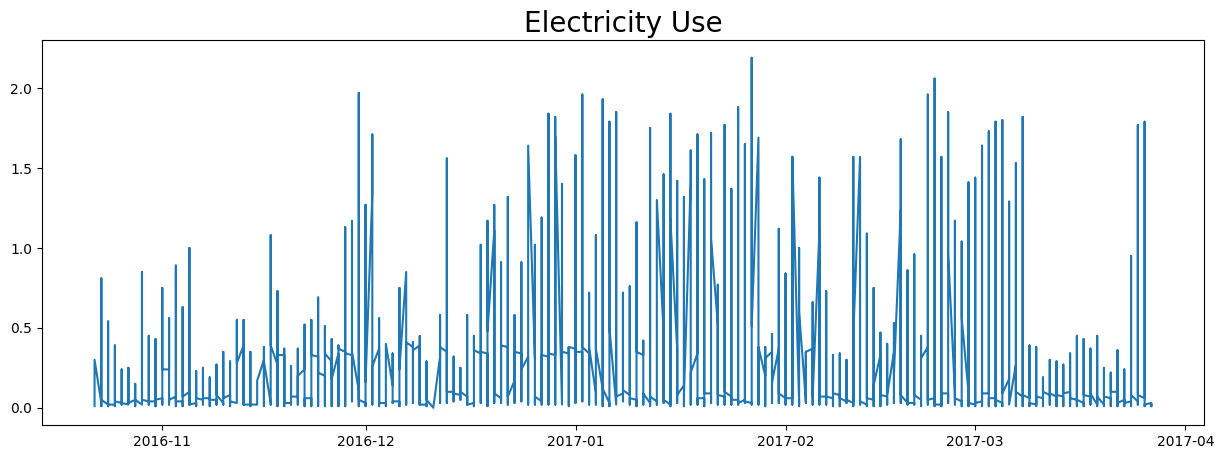

In [ ]:
dates = df['DATE'].values
usage = df['USAGE'].values

plt.figure(figsize=(15,5))
plt.plot(dates, usage)
plt.title('Electricity Use',
          fontsize=20)

In [ ]:
# Untuk merubah menjadi format yang dapat diterima oleh model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

window_size = 90
batch_size = 64
buffer = 1000

In [ ]:
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(df[['USAGE']])

train_set, test_set = train_test_split(usage, test_size=0.2, shuffle=False)

train_set = windowed_dataset(train_set,
                             window_size=window_size,
                             batch_size=batch_size,
                             shuffle_buffer=buffer)

test_set = windowed_dataset(test_set,
                            window_size=window_size,
                            batch_size=batch_size,
                            shuffle_buffer=buffer)

In [ ]:
# Model
model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(90, return_sequences=True),
        tf.keras.layers.LSTM(60),
        tf.keras.layers.Dense(60, activation="relu"),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dense(1),
])

optimizer = SGD(learning_rate=1.0000e-04, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Callbacks
class SaveBestMAEModelCallback(ModelCheckpoint):
  def __init__(self, filepath, monitor='mae', **kwargs):
    super().__init__(filepath, monitor=monitor, save_best_only=True, mode='min', **kwargs)
    self.best_mae = float('inf')

  def on_epoch_end(self, epoch, logs=None):
    current_mae = logs.get(self.monitor)
    if current_mae is not None and current_mae < self.best_mae:
      self.best_mae = current_mae
    super().on_epoch_end(epoch, logs)

num_epochs = 30
checkpoint_path = "bestModel.h5"
save_best_mae_callback = SaveBestMAEModelCallback(checkpoint_path, monitor='mae', verbose=1)

MAE (Mean Absolute Error) merupakan metrik evaluasi yang digunakan dalam regresi untuk mengukur selisih antara nilai prediksi dan nilai aktual.

In [ ]:
history = model.fit(train_set, epochs=num_epochs, validation_data=test_set, callbacks=[save_best_mae_callback])

Epoch 1/30
    184/Unknown - 15s 35ms/step - loss: 0.0521 - mae: 0.1780
Epoch 1: mae improved from inf to 0.17818, saving model to bestModel.h5
187/187 [==============================] - 17s 45ms/step - loss: 0.0524 - mae: 0.1782 - val_loss: 0.0449 - val_mae: 0.1218


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/30
183/187 [============================>.] - ETA: 0s - loss: 0.0494 - mae: 0.1627
Epoch 2: mae improved from 0.17818 to 0.16264, saving model to bestModel.h5
187/187 [==============================] - 6s 31ms/step - loss: 0.0495 - mae: 0.1626 - val_loss: 0.0430 - val_mae: 0.1147
Epoch 3/30
184/187 [============================>.] - ETA: 0s - loss: 0.0466 - mae: 0.1539
Epoch 3: mae improved from 0.16264 to 0.15362, saving model to bestModel.h5
187/187 [==============================] - 7s 38ms/step - loss: 0.0465 - mae: 0.1536 - val_loss: 0.0414 - val_mae: 0.1161
Epoch 4/30
184/187 [============================>.] - ETA: 0s - loss: 0.0440 - mae: 0.1507
Epoch 4: mae improved from 0.15362 to 0.15076, saving model to bestModel.h5
187/187 [==============================] - 5s 24ms/step - loss: 0.0441 - mae: 0.1508 - val_loss: 0.0404 - val_mae: 0.1210
Epoch 5/30
184/187 [============================>.] - ETA: 0s - loss: 0.0422 - mae: 0.1508
Epoch 5: mae did not improve from 0.15076


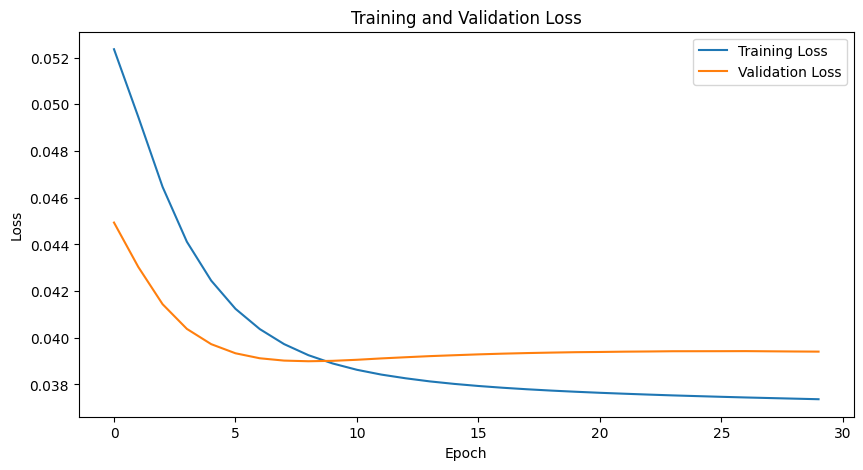

In [ ]:
# Plot loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

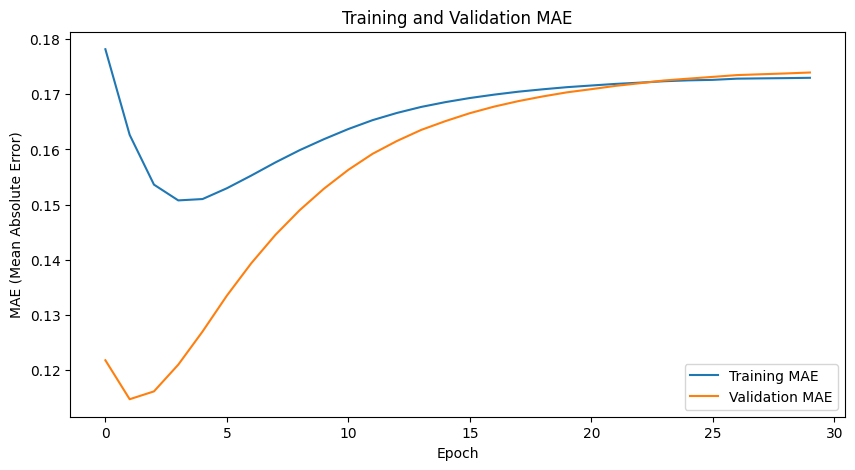

In [ ]:
# Plot MAE (Mean Absolute Error)
plt.figure(figsize=(10,5))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE (Mean Absolute Error)')
plt.title('Training and Validation MAE')
plt.show()

In [ ]:
# 10% of the scale of the data (MAE (Mean Absolute Error))
scale_of_data = df['USAGE'].max() - df['USAGE'].min()
threshold_mae = scale_of_data * 0.10

mae_from_model = round(save_best_mae_callback.best_mae, 3)


if mae_from_model < threshold_mae:
    print(f"MAE from the model: {mae_from_model}, is less than 10% of the scale of the data ({threshold_mae}).")
else:
    print(f"MAE from the model ({mae_from_model}) is greater than or equal to 10% of the scale of the data.")

MAE from the model: 0.151, is less than 10% of the scale of the data (0.219).
